In [16]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import rioxarray as rxr
from concurrent.futures import ThreadPoolExecutor
import warnings
import geopandas as gpd
from pylab import rcParams
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [17]:
#### Here we set the configuration
resolution = "p05"
region = [-180,180,-60,90]
ROOT_DIR = "/share/home/dq076/bedrock/data/"
data_path = ROOT_DIR
shp_path = ROOT_DIR + 'Shp/'
fig_path = ROOT_DIR + 'fig/'

In [18]:
def load_and_flatten_data(file_name, variable_name, index=None, path=''):
    try:
        with nc.Dataset(f"{path}{file_name}.nc") as dataset:
            data = dataset[variable_name][index, :, :].flatten() if index is not None else dataset[variable_name][:, :].flatten()
        return data
    except Exception as e:
        warnings.warn(f"Error loading {file_name}.nc or variable {variable_name}: {e}")
        return None

def load_lat_lon(data_path):
    try:
        with nc.Dataset(f"{data_path}Sbedrock_tmp1.nc") as dataset:
            lat = dataset['lat'][:]
            lon = dataset['lon'][:]
            # Use meshgrid for efficient grid creation
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            return lat_grid.ravel(), lon_grid.ravel()
    except Exception as e:
        warnings.warn(f"Error loading lat/lon from masking_criteria/mask_combine_all.nc4: {e}")
        return None, None

def load_all_data(file_variable_list, data_path='data/run/'):
    # Initialize DataFrame
    df = pd.DataFrame()

    # Load lat/lon first
    lat, lon = load_lat_lon(data_path)
    if lat is None or lon is None:
        raise RuntimeError("Failed to load latitude/longitude data")
    df['lat'] = lat
    df['lon'] = lon

    # Load other variables
    for file_name, variable_name, index in file_variable_list:
        data = load_and_flatten_data(file_name, variable_name, index, data_path)
        if data is not None:
            df[file_name] = data

    return df

# Configuration
file_variable_list = [
    ('Sbedrock_tmp1', 'Sbedrock', None),
    ('Sr_tmp1', 'Sr', None),
]

# Load all data
try:
    df = load_all_data(file_variable_list, data_path)

    # area_sum = df['Area'].sum() / 1e12
    # df = df[df['masking_criteria/mask_combine_all'] == 1]
    # area_mask_sum = df['Area'].sum() / 1e12
    # area_tropics = df[(df['lat'] > -23.5) & (df['lat'] < 23.5)]['Area'].sum() / 1e12
    # area_subarctic = df[(df['lat'] > 50) & (df['lat'] < 66.5)]['Area'].sum() / 1e12

    # print(f"Total area: {area_sum:.4f} million km²")
    # print(f"Masked area: {area_mask_sum:.4f} million km²")
    # print(f"Tropical area (-23.5° to 23.5°): {area_tropics:.4f} million km²")
    # print(f"Subarctic area (50° to 66.5°): {area_high_lat:.4f} million km²")
    # df = df.drop(columns=['masking_criteria/mask_combine_all'])

except Exception as e:
    print(f"Error processing data: {e}")
df = load_all_data(file_variable_list, data_path)

df

lat      lon  Sbedrock_tmp1  Sr_tmp1
0        -89.975 -179.975            0.0      0.0
1        -89.975 -179.925            0.0      0.0
2        -89.975 -179.875            0.0      0.0
3        -89.975 -179.825            0.0      0.0
4        -89.975 -179.775            0.0      0.0
...          ...      ...            ...      ...
25919995  89.975  179.775            0.0      0.0
25919996  89.975  179.825            0.0      0.0
25919997  89.975  179.875            0.0      0.0
25919998  89.975  179.925            0.0      0.0
25919999  89.975  179.975            0.0      0.0

[25920000 rows x 4 columns]

In [19]:
pd.set_option('display.max_columns', None)

params = {'font.family': 'Arial',
          'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

font_properties = fm.FontProperties(family='Arial', weight='bold')
size = 0.0005

In [20]:
df1 = df.copy()
shp = gpd.GeoDataFrame.from_file(shp_path+'World_CN/ne_10m_admin_0_countries_chn.shp')

In [21]:
def draw(df1,name,level,cmap):
    df1 = df1[df1[name[0]] > 0]

    fig = plt.figure(figsize=(12, 6), dpi=300)

    fig.subplots_adjust(left=0.05, right=0.98, 
                    bottom=0.14, top=0.95, hspace=0.25) 
        
    #Create a subgraph grid with 2 rows and 3 columns
    gs = GridSpec(2, 6)
    ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

    # Set drawing mode(note:extent's lat from positive to negative)
    img = ax.scatter(df1['lon'], df1['lat'], c=df1[name[0]], 
                    s=1, linewidths=0, edgecolors="k", 
                    cmap=cmap, zorder=1, vmin=level[0], vmax=level[-1])

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0)  

    ax.set_xlim(region[0], region[1])
    ax.set_ylim(region[2], region[3])

    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(region)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # ax.grid(ls = "--", lw = 0.25, color = "#4E616C")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', color='#4E616C')   
    gl.xlocator = ticker.FixedLocator(np.arange(-120, 181, 60)) 
    gl.ylocator = ticker.FixedLocator(np.arange(-60, 91, 30))    

    # From the bottom left corner x, y, width, height
    custom_ticks = [0, 100, 200, 300, 400]
    # cbar_ax = fig.add_axes([0.4, 0.14, 0.4, 0.03], frameon = False) 
    cbar_ax = fig.add_axes([0.1, 0.06, 0.8, 0.04], frameon = True) 
    cb = fig.colorbar(img, 
                    drawedges=True,
                    ticks=level, 
                    cax=cbar_ax, 
                    orientation='horizontal',
                    spacing='uniform')

    cb.ax.tick_params(labelsize=20)
    cb.ax.yaxis.set_tick_params(direction='out', width=1.5)
    # for label in cb.ax.get_xticklabels() + cb.ax.get_yticklabels():
    #     label.set_fontproperties(font_properties)
    cb.set_label(f'{name[3]}', fontsize=30, fontweight='bold')

    cb.outline.set_visible(True)
    cb.outline.set_edgecolor('#333333')
    cb.outline.set_linewidth(2)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_753730/4026649588.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


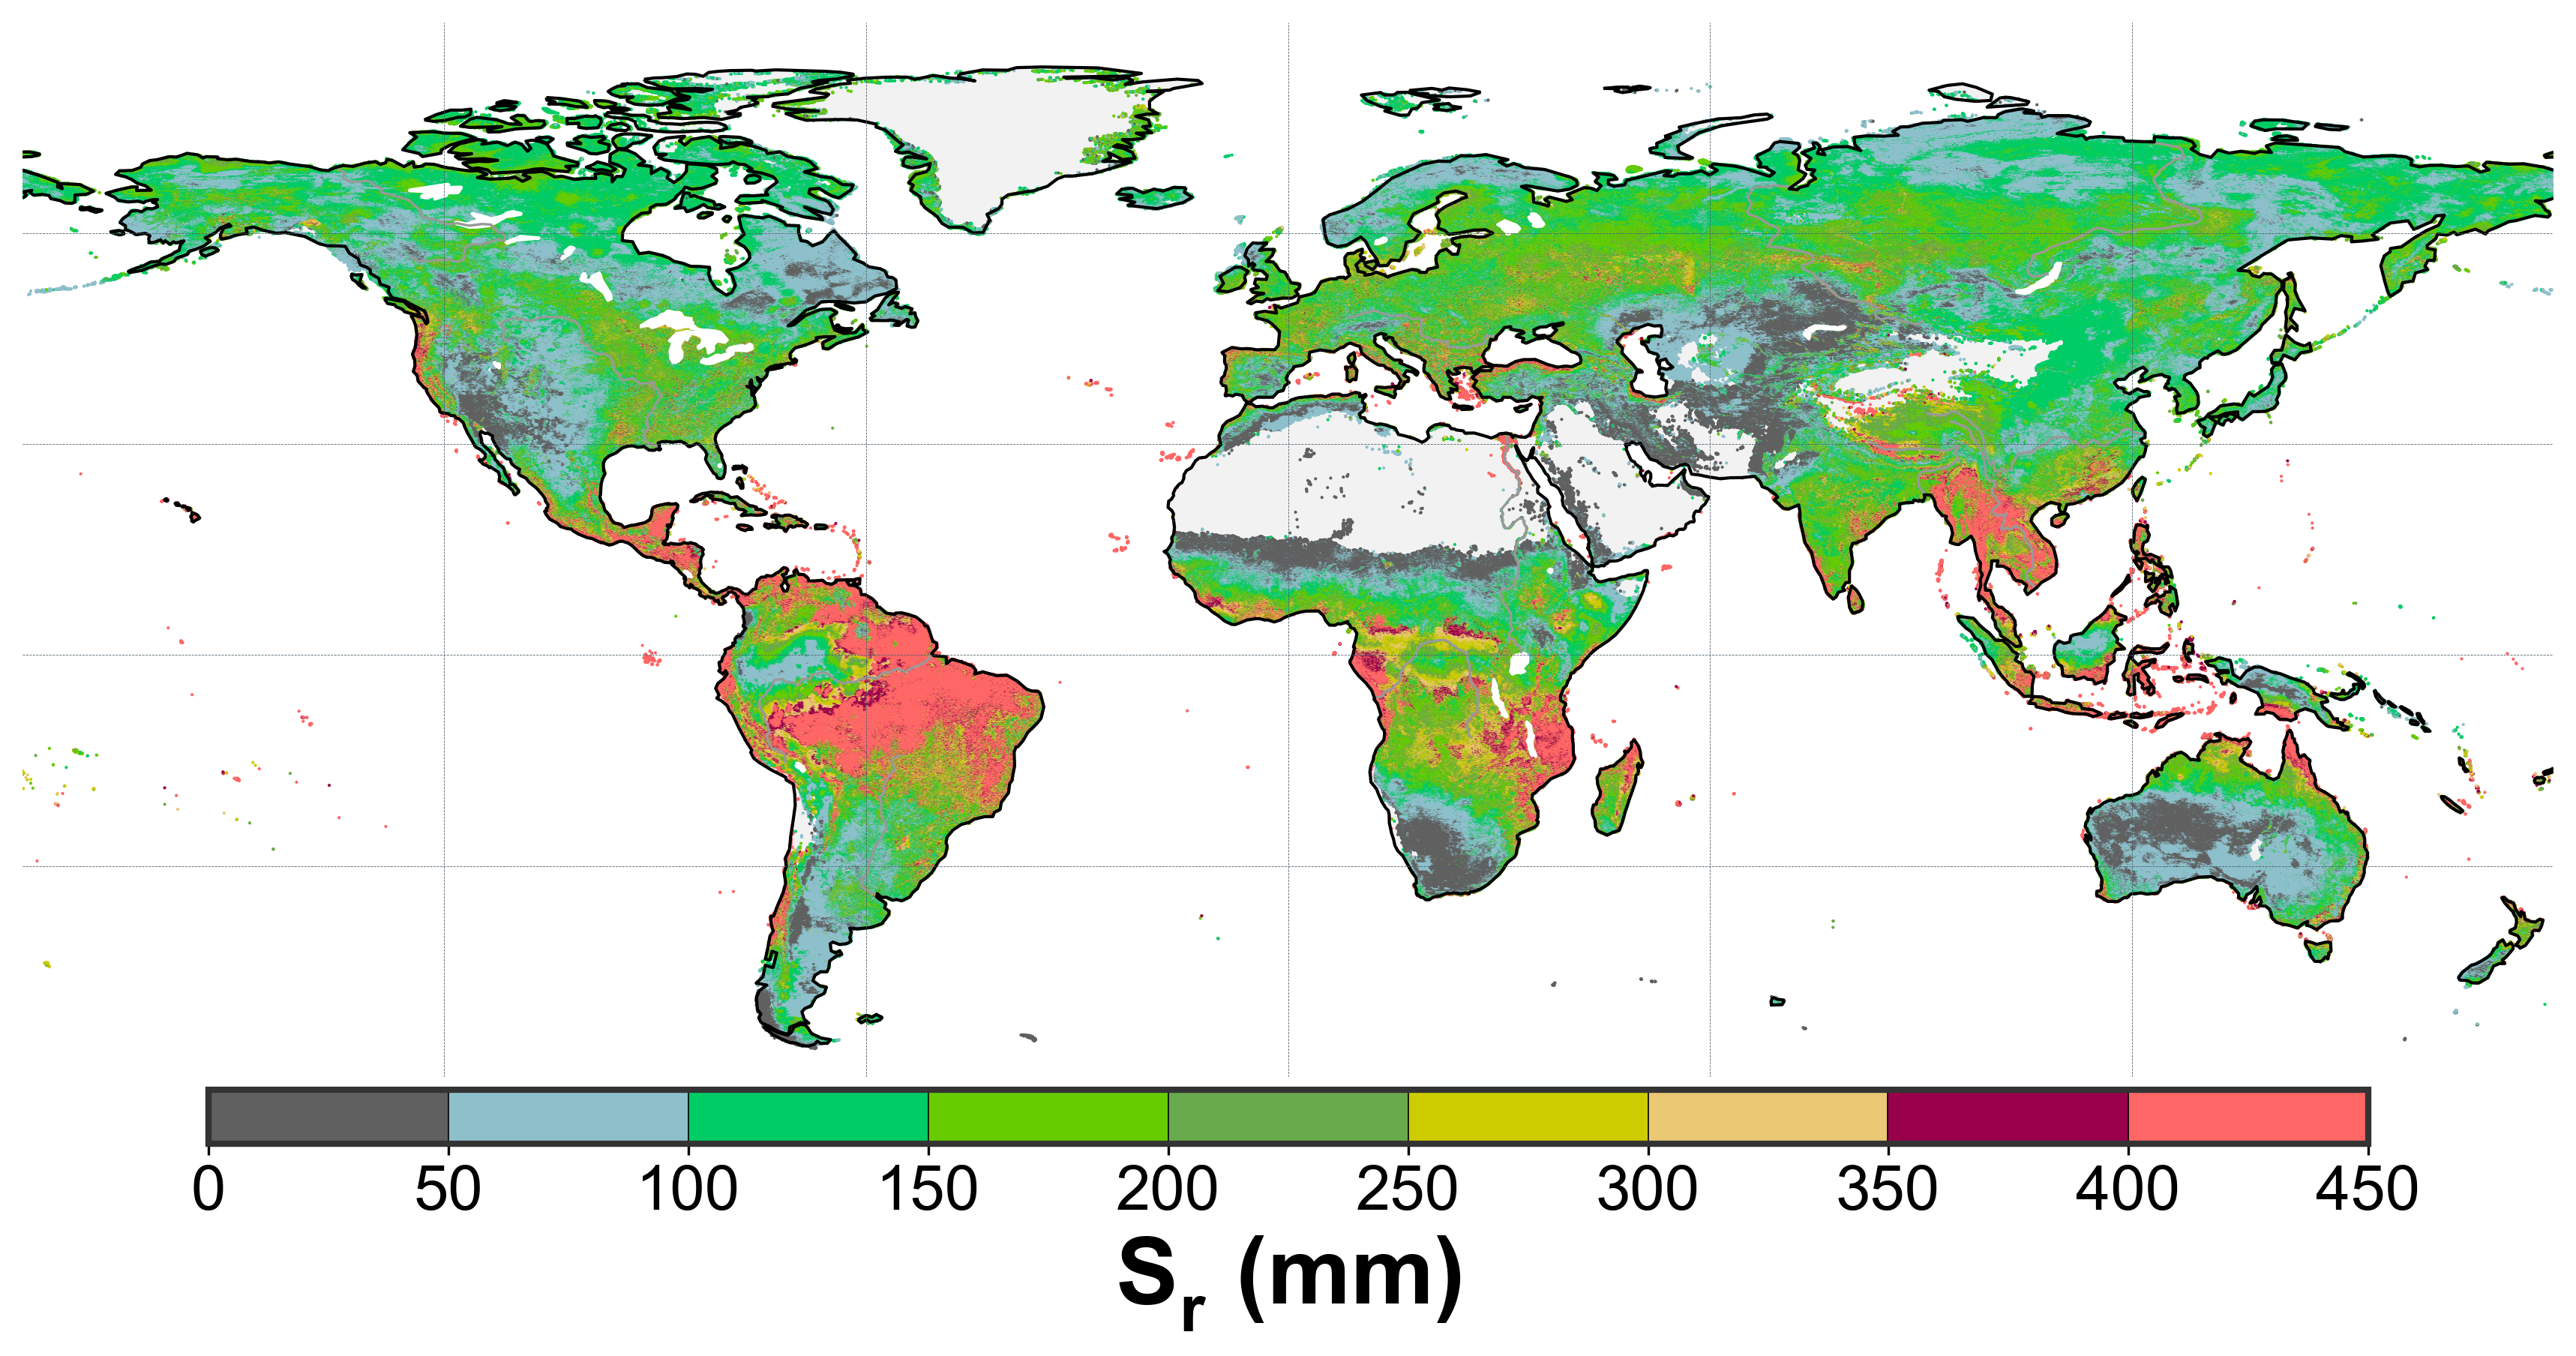

In [22]:
rgb_list = ['#606060','#8ec0cb','#00CC66','#66CC00',
                                '#69aa4c','#CCCC00','#ebc874','#99004C','#FF6666']

name = [f'Sr_tmp1', 'Sr', 'Sr', '$S_{r}$ (mm)']
level = np.arange(0,500,50)
cmap = colors.ListedColormap(rgb_list)
draw(df1,name,level,cmap)

/tmp/ipykernel_753730/4026649588.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


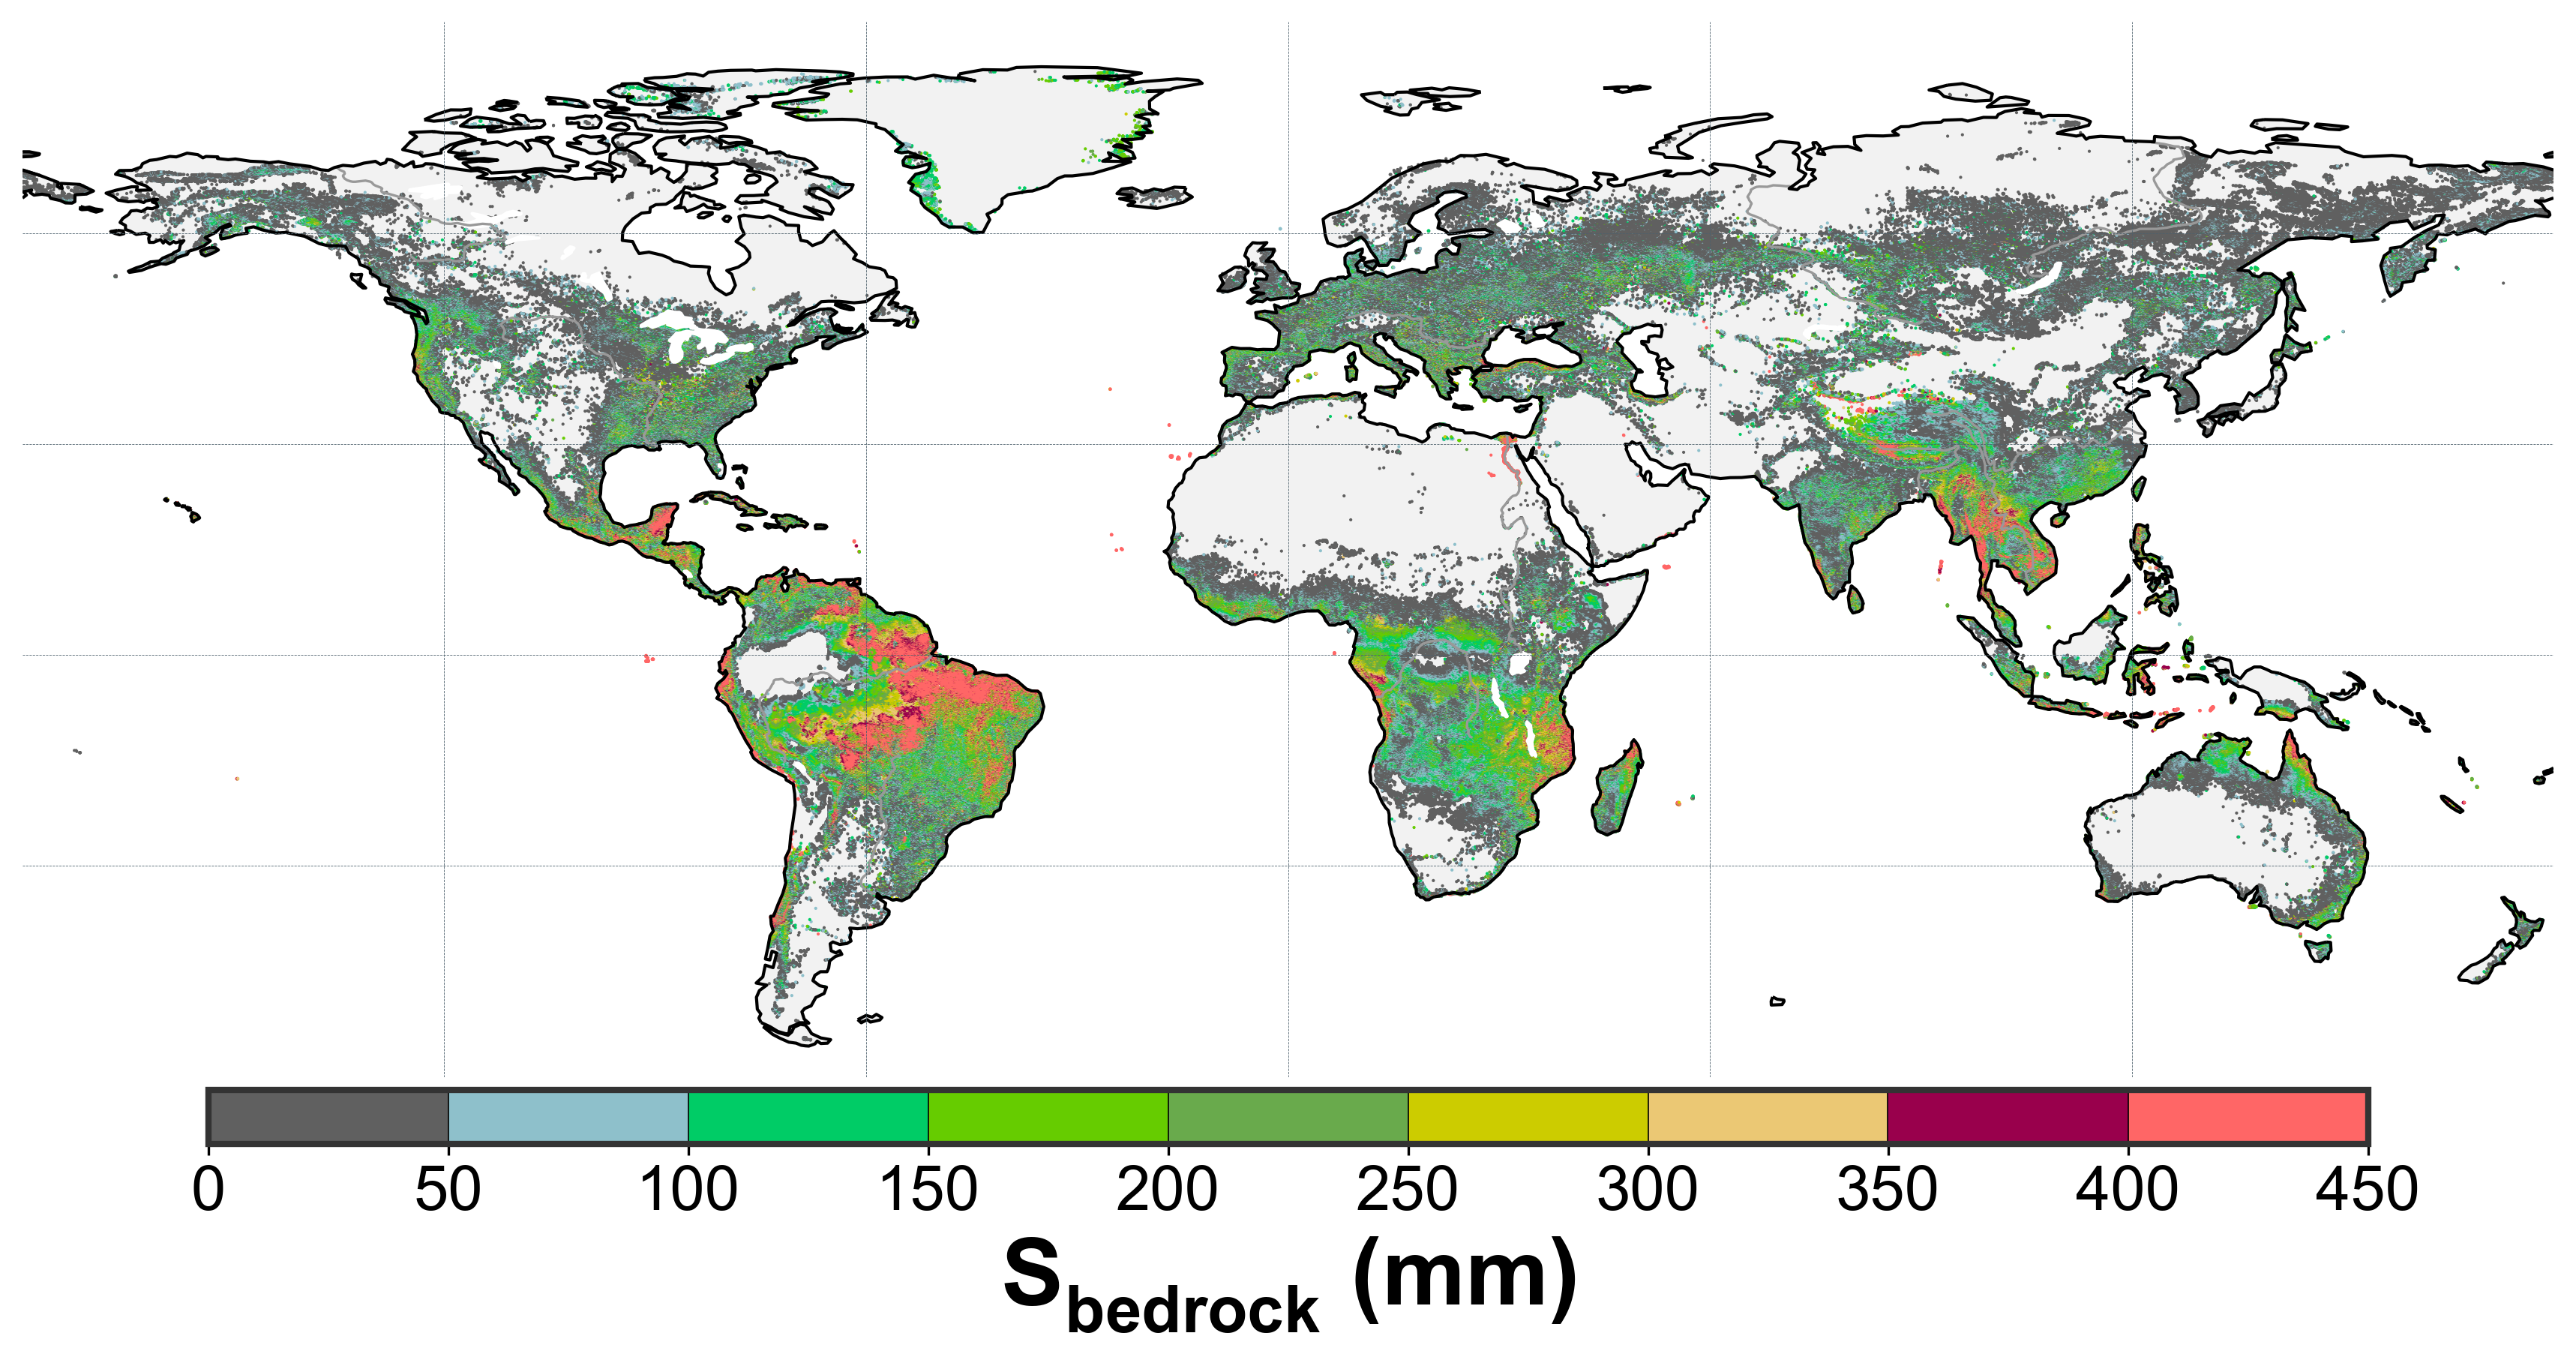

In [23]:
rgb_list = ['#606060','#8ec0cb','#00CC66','#66CC00',
                                '#69aa4c','#CCCC00','#ebc874','#99004C','#FF6666']

name = [f'Sbedrock_tmp1', 'Sbedrock', 'Sbedrock', '$S_{bedrock}$ (mm)']
level = np.arange(0,500,50)
cmap = colors.ListedColormap(rgb_list)
draw(df1,name,level,cmap)